# Below are explorations of deep learning architectures and the results we use in our final writeup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import xarray as xr
import rasterio as rio
import rioxarray
import math
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import pandas as pd
import os

import deep_snow.models
from deep_snow.dataset import norm_dict
from deep_snow.utils import calc_norm, undo_norm, calc_dowy
from tqdm import tqdm
import shutil

In [2]:
# we see the directory below contains our ai-ready data
files = glob("/mnt/c/Users/Jacke/uw/courses/aut24/ml_geo/jack_subsets/ncs/*.nc")
len(files)

3540

# Model Architecture Exploration

In [3]:
# first, let's just create a basic data pipeline to feed into a standard CNN
from torch.utils.data import DataLoader, TensorDataset, random_split
from deep_snow.dataset import norm_dict
from deep_snow.utils import calc_norm, undo_norm

In [ ]:
# global mins and maxes for scaling
norm_dict = {'aso_sd':[0, 25],
             'vv':[-59, 30],
             'vh':[-65, 17],
             'cr':[-43, 16],
             'delta_cr':[-33, 27],
             'AOT':[0, 572],
             'coastal':[0, 24304],
             'blue':[0, 23371],
             'green':[0, 26440],
             'red':[0, 21576],
             'red_edge1':[0, 20796],
             'red_edge2':[0, 20432],
             'red_edge3':[0, 20149],
             'nir':[0, 21217],
             'water_vapor':[0, 18199],
             'swir1':[0, 17669],
             'swir2':[0, 17936],
             'scene_class_map':[0, 15],
             'water_vapor_product':[0, 6518],
             'elevation':[-100, 9000],
             'aspect':[0, 360],
             'slope':[0, 90],
             'curvature':[-22, 22],
             'tpi':[-164, 167],
             'tri':[0, 913],
             'latitude':[-90, 90],
             'longitude':[-180, 180],
             'dowy': [0, 365]}

In [5]:
# Process each file and normalize the relevant features
def process_file(file_path):
    ds = xr.open_dataset(file_path)
    # Normalize features using the norm_dict
    data_dict = {}
    data_dict['latitude'] = calc_norm(torch.Tensor(ds['latitude'].values), norm_dict['latitude'])
    data_dict['longitude'] = calc_norm(torch.Tensor(ds['longitude'].values), norm_dict['longitude'])
    data_dict['elevation'] = calc_norm(torch.Tensor(ds['elevation'].values), norm_dict['elevation'])
    data_dict['slope'] = calc_norm(torch.Tensor(ds['slope'].values), norm_dict['slope'])
    data_dict['tri'] = calc_norm(torch.Tensor(ds['tri'].values), norm_dict['tri'])
    data_dict['tpi'] = calc_norm(torch.Tensor(ds['tpi'].values), norm_dict['tpi'])
    data_dict['dowy'] = calc_norm(torch.Tensor(ds['dowy'].values), norm_dict['dowy'])
    data_dict['fcf'] = torch.Tensor(ds['fcf'].values)
    # Reshape PC components to 2D
    s1_pc1_2d = ds['s1_pc1'].values.reshape(128, 128)
    s1_pc2_2d = ds['s1_pc2'].values.reshape(128, 128)
    s2_pc1_2d = ds['s2_pc1'].values.reshape(128, 128)
    s2_pc2_2d = ds['s2_pc2'].values.reshape(128, 128)
    s2_pc3_2d = ds['s2_pc3'].values.reshape(128, 128)
    # Stack normalized features
    features = np.stack([
        data_dict['elevation'].numpy(),
        data_dict['slope'].numpy(),
        data_dict['tri'].numpy(),
        data_dict['tpi'].numpy(),
        data_dict['latitude'].numpy(),
        data_dict['longitude'].numpy(),
        s1_pc1_2d,
        s1_pc2_2d,
        s2_pc1_2d,
        s2_pc2_2d,
        s2_pc3_2d,
        data_dict['fcf'].numpy(),
        data_dict['dowy'].numpy()
    ], axis=0)
    target = ds['aso_sd'].values
    return features, target

# Create datasets and data loaders
def create_dataset(file_list):
    features_list = []
    targets_list = []
    for file in file_list:
        features, target = process_file(file)
        features_list.append(torch.FloatTensor(features))
        targets_list.append(torch.FloatTensor(target))
    features_tensor = torch.stack(features_list)
    targets_tensor = torch.stack(targets_list)
    return TensorDataset(features_tensor, targets_tensor)

In [6]:
import random
# Split files into train, test, and validation sets
random.shuffle(files)
files_subset = files[:]
# Calculate the sizes for each split
train_size = int(0.7 * len(files_subset))  # 70% for training
test_size = int(0.2 * len(files_subset))   # 20% for testing
val_size = len(files_subset) - train_size - test_size  # Remaining 10% for validation
# Create the splits
train_files = files_subset[:train_size]
test_files = files_subset[train_size:train_size + test_size]
val_files = files_subset[train_size + test_size:]
# Create datasets
train_dataset = create_dataset(train_files)
test_dataset = create_dataset(test_files)
val_dataset = create_dataset(val_files)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [11]:
# Print shapes for training loader
for features, targets in train_loader:
    print("Training batch shapes:")
    print(f"Features: {features.shape}")
    print(f"Targets: {targets.shape}")
    break
# Print shapes for test loader
for features, targets in test_loader:
    print("\nTest batch shapes:")
    print(f"Features: {features.shape}")
    print(f"Targets: {targets.shape}")
    break
# Print shapes for validation loader
for features, targets in val_loader:
    print("\nValidation batch shapes:")
    print(f"Features: {features.shape}")
    print(f"Targets: {targets.shape}")
    break

Training batch shapes:
Features: torch.Size([32, 13, 128, 128])
Targets: torch.Size([32, 128, 128])

Test batch shapes:
Features: torch.Size([32, 13, 128, 128])
Targets: torch.Size([32, 128, 128])

Validation batch shapes:
Features: torch.Size([32, 13, 128, 128])
Targets: torch.Size([32, 128, 128])


In [8]:
class SnowDepthCNN(nn.Module):
    def __init__(self):
        super(SnowDepthCNN, self).__init__()
        # First conv layer: (12, 128, 128) -> (32, 128, 128)
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        # Second conv layer: (32, 128, 128) -> (16, 128, 128)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        # Final conv layer: (16, 128, 128) -> (1, 128, 128)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1)
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x.squeeze(1)  # Remove channel dimension to match target shape

In [7]:
def train_and_evaluate_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device):
    """
    Train, validate, and test the model.

    Args:
        model (nn.Module): The PyTorch model to train and evaluate.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (Loss): The loss function.
        optimizer (Optimizer): The optimizer for model training.
        num_epochs (int): Number of training epochs.
        device (torch.device): Device to use for computation.

    Returns:
        tuple: A tuple containing training losses, validation losses, and final test loss.
    """
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for features, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                val_loss += criterion(outputs, targets).item()
        
        # Compute average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
    
    # Testing
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            test_loss += criterion(outputs, targets).item()

    final_test_loss = test_loss / len(test_loader)
    print(f'\nFinal Test Loss: {final_test_loss:.4f}')

    return train_losses, val_losses, final_test_loss

In [ ]:
# Initialize model
model = SnowDepthCNN()
# Loss function: MAE is appropriate for continuous regression problems like snow depth
criterion = nn.L1Loss()
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
# Call the function
train_losses, val_losses, test_loss = train_and_evaluate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

Epoch 1: 100%|██████████| 78/78 [00:14<00:00,  5.32it/s]


Epoch [1/10]
Training Loss: 1.4825
Validation Loss: 1.5835


Epoch 2: 100%|██████████| 78/78 [00:16<00:00,  4.83it/s]


Epoch [2/10]
Training Loss: 1.1928
Validation Loss: 0.8901


Epoch 3: 100%|██████████| 78/78 [00:14<00:00,  5.56it/s]


Epoch [3/10]
Training Loss: 0.9605
Validation Loss: 0.8445


Epoch 4: 100%|██████████| 78/78 [00:16<00:00,  4.85it/s]


Epoch [4/10]
Training Loss: 0.6583
Validation Loss: 0.8170


Epoch 5: 100%|██████████| 78/78 [00:14<00:00,  5.37it/s]


Epoch [5/10]
Training Loss: 0.6441
Validation Loss: 0.7998


Epoch 6: 100%|██████████| 78/78 [00:14<00:00,  5.34it/s]


Epoch [6/10]
Training Loss: 0.6282
Validation Loss: 0.7824


Epoch 7: 100%|██████████| 78/78 [00:15<00:00,  4.92it/s]


Epoch [7/10]
Training Loss: 0.6072
Validation Loss: 0.7557


Epoch 8: 100%|██████████| 78/78 [00:14<00:00,  5.43it/s]


Epoch [8/10]
Training Loss: 0.5887
Validation Loss: 0.7359


Epoch 9: 100%|██████████| 78/78 [00:16<00:00,  4.74it/s]


Epoch [9/10]
Training Loss: 0.5753
Validation Loss: 0.7121


Epoch 10: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Epoch [10/10]
Training Loss: 0.5649
Validation Loss: 0.6964

Final Test Loss: 0.5653


In [ ]:
# great, we have a basic CNN implemented
# now let's explore other architectures for a preliminary search for the best architecture for our problem

In [12]:
# Process each file and normalize the relevant features
def process_file(file_path):
    ds = xr.open_dataset(file_path)
    # Normalize features using the norm_dict
    data_dict = {}
    data_dict['latitude'] = calc_norm(torch.Tensor(ds['latitude'].values), norm_dict['latitude'])
    data_dict['longitude'] = calc_norm(torch.Tensor(ds['longitude'].values), norm_dict['longitude'])
    data_dict['elevation'] = calc_norm(torch.Tensor(ds['elevation'].values), norm_dict['elevation'])
    data_dict['slope'] = calc_norm(torch.Tensor(ds['slope'].values), norm_dict['slope'])
    data_dict['tri'] = calc_norm(torch.Tensor(ds['tri'].values), norm_dict['tri'])
    data_dict['tpi'] = calc_norm(torch.Tensor(ds['tpi'].values), norm_dict['tpi'])
    data_dict['dowy'] = calc_norm(torch.Tensor(ds['dowy'].values), norm_dict['dowy'])
    data_dict['fcf'] = torch.Tensor(ds['fcf'].values)
    # Reshape PC components to 2D
    s1_pc1_2d = ds['s1_pc1'].values.reshape(128, 128)
    s1_pc2_2d = ds['s1_pc2'].values.reshape(128, 128)
    s2_pc1_2d = ds['s2_pc1'].values.reshape(128, 128)
    s2_pc2_2d = ds['s2_pc2'].values.reshape(128, 128)
    s2_pc3_2d = ds['s2_pc3'].values.reshape(128, 128)
    # Stack normalized features
    features = np.stack([
        data_dict['elevation'].numpy(),
        data_dict['slope'].numpy(),
        data_dict['tri'].numpy(),
        data_dict['tpi'].numpy(),
        data_dict['latitude'].numpy(),
        data_dict['longitude'].numpy(),
        s1_pc1_2d,
        s1_pc2_2d,
        s2_pc1_2d,
        s2_pc2_2d,
        s2_pc3_2d,
        data_dict['fcf'].numpy(),
        data_dict['dowy'].numpy()
    ], axis=0)
    target = ds['aso_sd'].values
    # Add channel dimension to target
    target = target[np.newaxis, ...]  # This makes it (1, 128, 128)
    return features, target

# Create datasets and data loaders
def create_dataset(file_list):
    features_list = []
    targets_list = []
    for file in file_list:
        features, target = process_file(file)
        features_list.append(torch.FloatTensor(features))
        targets_list.append(torch.FloatTensor(target))
    features_tensor = torch.stack(features_list)
    targets_tensor = torch.stack(targets_list)
    return TensorDataset(features_tensor, targets_tensor)
import random
# Split files into train, test, and validation sets
random.shuffle(files)
files_subset = files[:]
# Calculate the sizes for each split
train_size = int(0.7 * len(files_subset))  # 70% for training
test_size = int(0.2 * len(files_subset))   # 20% for testing
val_size = len(files_subset) - train_size - test_size  # Remaining 10% for validation
# Create the splits
train_files = files_subset[:train_size]
test_files = files_subset[train_size:train_size + test_size]
val_files = files_subset[train_size + test_size:]
# Create datasets
train_dataset = create_dataset(train_files)
test_dataset = create_dataset(test_files)
val_dataset = create_dataset(val_files)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=13, out_channels=1):
        super(UNet, self).__init__()
        # Encoding path
        self.enc1 = self.contract_block(in_channels, 64, 3)
        self.enc2 = self.contract_block(64, 128, 3)
        # Bottleneck
        self.bottleneck = self.contract_block(128, 256, 3)
        # Decoding path
        self.dec2 = self.expand_block(256, 128, 3)
        self.dec1 = self.expand_block(128, 64, 3)
        # Final output layer
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
    def contract_block(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

    def expand_block(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        )
    def forward(self, x):
        # Encoding
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        bottleneck = self.bottleneck(enc2)
        dec2 = self.dec2(bottleneck)
        dec1 = self.dec1(dec2)
        output = self.final(dec1)
        # Resize the output to match the input size
        return F.interpolate(output, size=(x.size(2), x.size(3)), mode='bilinear', align_corners=False)

In [15]:
class UNet(nn.Module):
    def __init__(self, in_channels=13, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoding path
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.enc2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Decoding path
        self.upsample2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoding
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc2)
        
        # Decoding
        dec2 = self.upsample2(bottleneck)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upsample1(dec2)
        dec1 = self.dec1(dec1)
        
        output = self.final(dec1)
        return output

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
train_losses, val_losses, test_loss = train_and_evaluate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

Epoch 1: 100%|██████████| 78/78 [04:44<00:00,  3.65s/it]


Epoch [1/10]
Training Loss: 0.6563
Validation Loss: 0.6168


Epoch 2: 100%|██████████| 78/78 [05:01<00:00,  3.86s/it]


Epoch [2/10]
Training Loss: 0.6472
Validation Loss: 0.6156


Epoch 3: 100%|██████████| 78/78 [05:00<00:00,  3.86s/it]


Epoch [3/10]
Training Loss: 0.5967
Validation Loss: 0.5878


Epoch 4: 100%|██████████| 78/78 [04:42<00:00,  3.62s/it]


Epoch [4/10]
Training Loss: 0.5704
Validation Loss: 0.5742


Epoch 5: 100%|██████████| 78/78 [05:05<00:00,  3.91s/it]


Epoch [5/10]
Training Loss: 0.5521
Validation Loss: 0.5489


Epoch 6: 100%|██████████| 78/78 [05:12<00:00,  4.00s/it]


Epoch [6/10]
Training Loss: 0.5338
Validation Loss: 0.5438


Epoch 7: 100%|██████████| 78/78 [04:41<00:00,  3.62s/it]


Epoch [7/10]
Training Loss: 0.5144
Validation Loss: 0.5457


Epoch 8: 100%|██████████| 78/78 [04:55<00:00,  3.79s/it]


Epoch [8/10]
Training Loss: 0.5068
Validation Loss: 0.5306


Epoch 9: 100%|██████████| 78/78 [05:03<00:00,  3.89s/it]


Epoch [9/10]
Training Loss: 0.5072
Validation Loss: 0.5373


Epoch 10: 100%|██████████| 78/78 [05:08<00:00,  3.95s/it]


Epoch [10/10]
Training Loss: 0.4946
Validation Loss: 0.5230

Final Test Loss: 0.4867


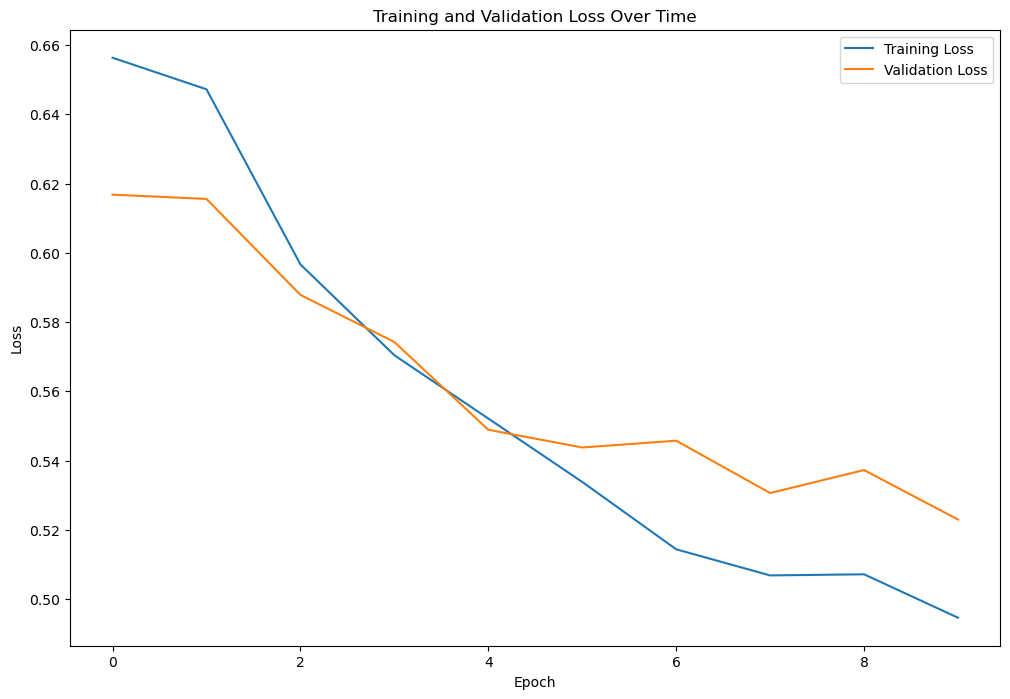

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(False)
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/unet_loss.png", bbox_inches='tight', dpi=300)
plt.show()

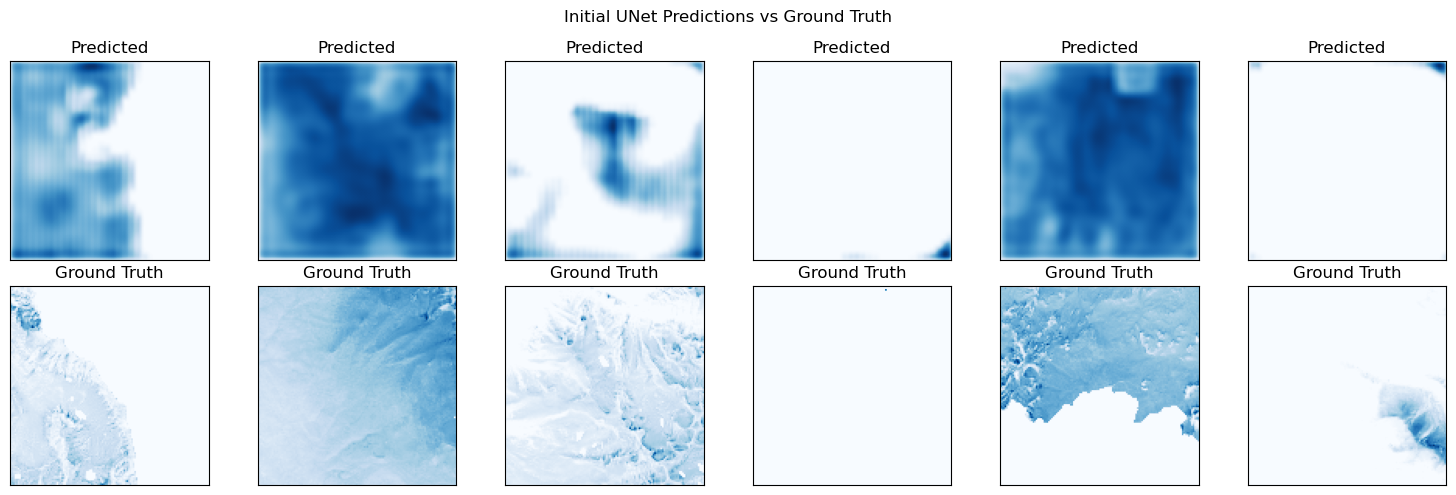

In [43]:
import random
import matplotlib.pyplot as plt
#random.seed(42)
# Get a batch of test data
input, target = next(iter(test_loader))

# Generate predictions
pred = model(input.to(device))
pred = pred.squeeze()  # Remove channel dimension
pred = pred.detach().cpu().numpy()  # Convert to numpy array

# Ensure target is the right shape
target = target.squeeze()  # Remove channel dimension if present
target = target.numpy()  # Convert to numpy array

# Visualization
N = 6
idxs = random.sample(range(pred.shape[0]), N)
fig, axs = plt.subplots(2, N, figsize=(15, 5), squeeze=True)

for i, idx in enumerate(idxs):
    axs[0, i].imshow(pred[idx], cmap='Blues')
    axs[1, i].imshow(target[idx], cmap='Blues')
    
    # Add titles
    axs[0, i].set_title('Predicted')
    axs[1, i].set_title('Ground Truth')

for axi in axs:
    for ax in axi:
        ax.set_xticks([])
        ax.set_yticks([])

plt.suptitle("Initial UNet Predictions vs Ground Truth")
plt.tight_layout()
plt.savefig("/mnt/c/Users/JackE/uw/courses/aut24/ml_geo/unet_preds.png", bbox_inches='tight', dpi=300)
plt.show()

In [21]:
input.shape

torch.Size([32, 13, 128, 128])

In [ ]:
# hmm doesn't seem to be doing particularly well but we see there's an error in our loss function
# that being said, we'll write off the UNet for this assignment as that took 30 minutes to run
# and we'll have to do a lot of hyperparameter tuning for this assignement

# in the real world, I'd correct this error and proceed again, but given the time constraints, I'll move on
# we'd be sitting here for a lot more hours than necessary if we were to correct the UNet and tune the hyperparameters on that model

In [13]:
# our third architecture to explore will be a resnet
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=1)
        self.shortcut = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )
    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return self.relu(x + shortcut)
class ResNetSnowDepth(nn.Module):
    def __init__(self):
        super(ResNetSnowDepth, self).__init__()
        # Initial convolution: (13, 128, 128) -> (32, 128, 128)
        self.initial_conv = nn.Conv2d(13, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        # Residual blocks
        self.res1 = ResidualBlock(32, 64)  # (32, 128, 128) -> (64, 128, 128)
        self.res2 = ResidualBlock(64, 128)  # (64, 128, 128) -> (128, 128, 128)
        self.res3 = ResidualBlock(128, 64)  # (128, 128, 128) -> (64, 128, 128)
        # Output layer: (64, 128, 128) -> (1, 128, 128)
        self.output_conv = nn.Conv2d(64, 1, kernel_size=1)
    def forward(self, x):
        x = self.relu(self.initial_conv(x))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.output_conv(x)
        return x.squeeze(1)  # Remove channel dimension to match target shape

In [14]:
model = ResNetSnowDepth()
model = model.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses, val_losses, test_loss = train_and_evaluate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

Epoch 1:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 78/78 [05:44<00:00,  4.41s/it]


Epoch [1/10]
Training Loss: 0.7284
Validation Loss: 0.8139


Epoch 2: 100%|██████████| 78/78 [06:02<00:00,  4.64s/it]


Epoch [2/10]
Training Loss: 0.6154
Validation Loss: 0.7910


Epoch 3: 100%|██████████| 78/78 [06:03<00:00,  4.66s/it]


Epoch [3/10]
Training Loss: 0.5923
Validation Loss: 0.7241


Epoch 4: 100%|██████████| 78/78 [06:02<00:00,  4.65s/it]


Epoch [4/10]
Training Loss: 0.5758
Validation Loss: 0.7488


Epoch 5: 100%|██████████| 78/78 [06:01<00:00,  4.63s/it]


Epoch [5/10]
Training Loss: 0.5608
Validation Loss: 0.6550


Epoch 6: 100%|██████████| 78/78 [05:58<00:00,  4.59s/it]


Epoch [6/10]
Training Loss: 0.5297
Validation Loss: 0.6006


Epoch 7: 100%|██████████| 78/78 [06:03<00:00,  4.66s/it]


Epoch [7/10]
Training Loss: 0.5322
Validation Loss: 0.6852


Epoch 8: 100%|██████████| 78/78 [06:07<00:00,  4.71s/it]


Epoch [8/10]
Training Loss: 0.5158
Validation Loss: 0.5812


Epoch 9: 100%|██████████| 78/78 [06:05<00:00,  4.69s/it]


Epoch [9/10]
Training Loss: 0.5045
Validation Loss: 0.5814


Epoch 10: 100%|██████████| 78/78 [06:03<00:00,  4.66s/it]


Epoch [10/10]
Training Loss: 0.4985
Validation Loss: 0.6400

Final Test Loss: 0.5247


In [ ]:
# above we see that the ResNet model is the best performing model and quite promising, but we also see that it takes
# over an hour to run a simple ResNet architecture as opposed to 30 minutes for a U-net and 3 minutes for a 
# basic CNN.
# 1 hour isn't a long runtime at all, but given that this is for a homework assignemnt that requires hyperparameter tuning
# we'll proceed with the simple CNN architecture rather than the ResNet architecture so we don't have to wait a lot of hours for 
# hyperparameter tuning. Running ResNet tuning overnight will be interesting, and something to explore, but for the sake of the assingment
# deadline, we can't risk an error or bug interrupting this

#### Parameter Tuning

In [17]:
# let's change our train and eval model function to get rid of print statements
def train_and_evaluate_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device, verbose=True):
    """
    Train, validate, and test the model.

    Args:
        model (nn.Module): The PyTorch model to train and evaluate.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (Loss): The loss function.
        optimizer (Optimizer): The optimizer for model training.
        num_epochs (int): Number of training epochs.
        device (torch.device): Device to use for computation.
        verbose (bool): Whether to print detailed progress for each epoch.

    Returns:
        tuple: A tuple containing training losses, validation losses, and final test loss.
    """
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features).squeeze(1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                val_loss += criterion(outputs, targets).item()
        
        # Compute average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Training Loss: {avg_train_loss:.4f}')
            print(f'Validation Loss: {avg_val_loss:.4f}')
    
    # Testing
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            test_loss += criterion(outputs, targets).item()

    final_test_loss = test_loss / len(test_loader)

    if verbose:
        print(f'\nFinal Test Loss: {final_test_loss:.4f}')

    return train_losses, val_losses, final_test_loss


In [18]:
import itertools
# Define the hyperparameter grid
learning_rates = [0.001, 0.0005, 0.0001]
num_layers_options = [3, 4, 5]
filter_sizes_options = [16, 32, 64]
# Results storage
tuning_results = []
# Define a function to create the model with variable layers and filter sizes
def create_model(num_layers, initial_filter_size):
    layers = []
    in_channels = 13
    for i in range(num_layers):
        out_channels = initial_filter_size if i == 0 else in_channels // 2
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    # Add the final layer
    layers.append(nn.Conv2d(in_channels, 1, kernel_size=1))
    return nn.Sequential(*layers)

# Train and evaluate models with different hyperparameters
for lr, num_layers, filter_size in itertools.product(learning_rates, num_layers_options, filter_sizes_options):
    print(f"\nTraining with learning rate={lr}, num_layers={num_layers}, filter_size={filter_size}")
    # Create the model
    model = create_model(num_layers, filter_size)
    model = model.to(device)
    # Define loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # Train the model
    train_losses, val_losses, test_loss = train_and_evaluate_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device,
        verbose=False,  # Suppress progress for each epoch
    )
    # Record the results
    tuning_results.append({
        "learning_rate": lr,
        "num_layers": num_layers,
        "filter_size": filter_size,
        "train_loss": train_losses[-1],
        "val_loss": val_losses[-1],
        "test_loss": test_loss,
    })
# Display the tuning results
print("\nHyperparameter Tuning Results:")
for result in tuning_results:
    print(result)



Training with learning rate=0.001, num_layers=3, filter_size=16

Training with learning rate=0.001, num_layers=3, filter_size=32

Training with learning rate=0.001, num_layers=3, filter_size=64

Training with learning rate=0.001, num_layers=4, filter_size=16

Training with learning rate=0.001, num_layers=4, filter_size=32

Training with learning rate=0.001, num_layers=4, filter_size=64

Training with learning rate=0.001, num_layers=5, filter_size=16

Training with learning rate=0.001, num_layers=5, filter_size=32

Training with learning rate=0.001, num_layers=5, filter_size=64

Training with learning rate=0.0005, num_layers=3, filter_size=16

Training with learning rate=0.0005, num_layers=3, filter_size=32

Training with learning rate=0.0005, num_layers=3, filter_size=64

Training with learning rate=0.0005, num_layers=4, filter_size=16

Training with learning rate=0.0005, num_layers=4, filter_size=32

Training with learning rate=0.0005, num_layers=4, filter_size=64

Training with lear

In [19]:
tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df.sort_values(by='test_loss', ascending=True).reset_index(drop=True)

,learning_rate,num_layers,filter_size,train_loss,val_loss,test_loss
0,0.0010,4,64,0.616152,0.811098,0.628715
1,0.0001,4,32,0.614485,0.812608,0.631464
2,0.0005,3,16,0.611082,0.817975,0.639505
3,0.0005,3,32,0.611968,0.821283,0.644834
4,0.0001,4,64,0.622577,0.825851,0.647030
5,0.0001,3,64,0.617545,0.824738,0.648433
6,0.0010,5,16,0.595409,0.829031,0.653437
7,0.0005,5,16,0.618858,0.830796,0.654767
8,0.0005,4,32,0.603227,0.831058,0.658468
9,0.0010,4,32,0.573038,0.834548,0.660361


In [ ]:
# we see above that we'll proceed with a learning rate of 0.0005, 4 layers, and a filter size of 64

# edit: i'm realizing that after ~2 hours of hyperparameter tuning and moving onto  PI-loss
#  that the 'best' model returned here is still worse than our simplest CNN. 
# The PI-loss is implemented on the model seen in the table above rather than the simpler one
# that performs best. But further in this notebook, we go back to tuning the simpler, better model

#### Incorporation of Physics-Informed Loss (via chatgpt)

In [47]:
class PhysicsInformedLoss(torch.nn.Module):
    def __init__(self, lambda_gradient=0.1):
        super(PhysicsInformedLoss, self).__init__()
        self.lambda_gradient = lambda_gradient

    def forward(self, predicted, target, features):
        # Add channel dimension to predicted since model output doesn't have it
        predicted = predicted.unsqueeze(1)
        target = target.unsqueeze(1)
        
        # Traditional MAE loss
        mae_loss = F.l1_loss(predicted, target)
        
        # Extract TPI and ensure it has matching dimensions
        tpi = features[:, 3:4, :, :]  # Keep channel dimension
        
        # Calculate gradients with padding to maintain size
        grad_predicted = F.pad(torch.abs(predicted[:, :, 1:, :] - predicted[:, :, :-1, :]), (0, 0, 1, 0))
        grad_target = F.pad(torch.abs(target[:, :, 1:, :] - target[:, :, :-1, :]), (0, 0, 1, 0))
        grad_tpi = F.pad(torch.abs(tpi[:, :, 1:, :] - tpi[:, :, :-1, :]), (0, 0, 1, 0))
        
        # Calculate terrain gradient loss
        terrain_gradient_loss = torch.mean(torch.abs(grad_predicted - grad_target) * grad_tpi)
        
        return mae_loss + self.lambda_gradient * terrain_gradient_loss

Physics-informed loss explanation (ChatGPT's, I need to research this on my own and understand it better and what lambda to use):

Explanation of Physics-Informed Loss:


Traditional MAE Loss:

This term captures the basic prediction accuracy, comparing the predicted snow depth with the true snow depth at each pixel.


Terrain Gradient Loss:

We compute the gradient of both the predicted and actual snow depth with respect to neighboring pixels (in both the x and y directions).
The terrain gradient loss ensures that the model doesn’t produce unrealistic sharp transitions in snow depth where there should be smooth changes, especially considering the relationship between snow depth and elevation. This helps to model the spatial continuity of snow depth, which should naturally change with elevation and other terrain features.


Weighting Factor 𝜆

The weighting factor λ controls the importance of the gradient loss relative to the traditional MAE loss. This allows you to balance between fitting the data and adhering to the physical constraints.


Relevance to the Geoscientific Problem:

Snow Accumulation and Melting: Snow depth predictions should adhere to physical laws such as the conservation of mass. Sharp, discontinuous changes in snow depth are not physically realistic, especially when they occur across similar elevations.


Terrain Influence: 
Elevation plays a key role in snow accumulation and melting. The higher the elevation, the greater the snow accumulation. The physics-informed loss ensures that the snow depth predictions are consistent with the terrain features, making the model more physically grounded.


Improved Generalization: 
By adding domain knowledge into the loss function, the model is guided to produce more physically realistic predictions. This can help prevent overfitting and lead to better generalization in real-world applications, where snow depth predictions are needed for tasks like avalanche forecasting, hydrological modeling, or climate studies.

In [48]:
class SnowDepthCNN(nn.Module):
    def __init__(self):
        super(SnowDepthCNN, self).__init__()
        # Define the 4 layers with filter size 64
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        
        # Fully connected layers adjusted for 64 filters
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128 * 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 128, 128)  # Reshape to match target dimensions
        
        return x

In [49]:
import torch
import json

def train_and_evaluate_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device, verbose=True, save_dir='weights'):
    """
    Train, validate, and test the model. Save model weights, logs, and metrics to JSON.

    Args:
        model (nn.Module): The PyTorch model to train and evaluate.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (Loss): The loss function.
        optimizer (Optimizer): The optimizer for model training.
        num_epochs (int): Number of training epochs.
        device (torch.device): Device to use for computation.
        verbose (bool): Whether to print detailed progress for each epoch.
        save_dir (str): Directory to save model weights, logs, and metrics.

    Returns:
        tuple: A tuple containing training losses, validation losses, and final test loss.
    """
    train_losses = []
    val_losses = []
    performance_metrics = {}

    # Make sure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features).squeeze(1)
            loss = criterion(outputs, targets, features)  # Pass features as well
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                val_loss += criterion(outputs, targets, features).item()  # Pass features as well
        
        # Compute average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Training Loss: {avg_train_loss:.4f}')
            print(f'Validation Loss: {avg_val_loss:.4f}')
        
        # Save logs after each epoch (optional)
        performance_metrics[f"epoch_{epoch+1}"] = {
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss
        }

    # Testing phase
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            test_loss += criterion(outputs, targets, features).item()  # Pass features as well

    final_test_loss = test_loss / len(test_loader)
    performance_metrics["final_test_loss"] = final_test_loss

    if verbose:
        print(f'\nFinal Test Loss: {final_test_loss:.4f}')
    
    # Save model weights to file
    model_weight_path = os.path.join(save_dir, 'jackk_pinn1.pth')
    torch.save(model.state_dict(), model_weight_path)

    # Save training logs and performance metrics to JSON file
    performance_metrics_path = os.path.join(save_dir, 'performance_metrics.json')
    with open(performance_metrics_path, 'w') as json_file:
        json.dump(performance_metrics, json_file, indent=4)

    return train_losses, val_losses, final_test_loss

In [50]:
#files_subset = files[:]
#random.shuffle(files_subset)
#train_size = int(0.7 * len(files_subset))  # 70% for training
#test_size = int(0.2 * len(files_subset))   # 20% for testing
#val_size = len(files_subset) - train_size - test_size  # Remaining 10% for validation
#train_files = files_subset[:train_size]
#test_files = files_subset[train_size:train_size + test_size]
#val_files = files_subset[train_size + test_size:]
#train_dataset = create_dataset(train_files)
#test_dataset = create_dataset(test_files)
#val_dataset = create_dataset(val_files)
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [51]:
# now train the physics-informed loss on the entire dataset
model = SnowDepthCNN()  # Your SnowDepthCNN model
loss_fn = PhysicsInformedLoss(lambda_gradient=0.1)  # Physics-Informed Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Train and evaluate the model using your custom function
train_losses, val_losses, test_loss = train_and_evaluate_model(
    model, train_loader, val_loader, test_loader, 
    criterion=loss_fn, optimizer=optimizer, 
    num_epochs=10, device=device, verbose=True
)

Epoch [1/10]
Training Loss: 0.6246
Validation Loss: 0.8120
Epoch [2/10]
Training Loss: 0.6141
Validation Loss: 0.8114
Epoch [3/10]
Training Loss: 0.6157
Validation Loss: 0.8114
Epoch [4/10]
Training Loss: 0.6154
Validation Loss: 0.8114
Epoch [5/10]
Training Loss: 0.6167
Validation Loss: 0.8114
Epoch [6/10]
Training Loss: 0.6141
Validation Loss: 0.8114
Epoch [7/10]
Training Loss: 0.6203
Validation Loss: 0.8114
Epoch [8/10]
Training Loss: 0.6156
Validation Loss: 0.8115
Epoch [9/10]
Training Loss: 0.6144
Validation Loss: 0.8114
Epoch [10/10]
Training Loss: 0.6146
Validation Loss: 0.8114

Final Test Loss: 0.6287


In [ ]:
# the physics-informed loss didn't perform any better than regular MAE loss, so we'll stick
# with MAE loss to keep it simpler

#### Exploration and Analysis (7%): Investigates losses, activation functions, and layer design, demonstrating a strong understanding of model behavior

In [ ]:
# let's go back to our classic CNN model to somewhat optimize the parameters requested

In [ ]:
class SnowDepthCNN(nn.Module):
    def __init__(self):
        super(SnowDepthCNN, self).__init__()
        # First conv layer: (12, 128, 128) -> (32, 128, 128)
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        # Second conv layer: (32, 128, 128) -> (16, 128, 128)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        # Final conv layer: (16, 128, 128) -> (1, 128, 128)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1)
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x.squeeze(1)  # Remove channel dimension to match target shape
def train_and_evaluate_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs, device):
    """
    Train, validate, and test the model.

    Args:
        model (nn.Module): The PyTorch model to train and evaluate.
        train_loader (DataLoader): DataLoader for the training dataset.
        val_loader (DataLoader): DataLoader for the validation dataset.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (Loss): The loss function.
        optimizer (Optimizer): The optimizer for model training.
        num_epochs (int): Number of training epochs.
        device (torch.device): Device to use for computation.

    Returns:
        tuple: A tuple containing training losses, validation losses, and final test loss.
    """
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for features, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                val_loss += criterion(outputs, targets).item()
        
        # Compute average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
    
    # Testing
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            test_loss += criterion(outputs, targets).item()

    final_test_loss = test_loss / len(test_loader)
    print(f'\nFinal Test Loss: {final_test_loss:.4f}')

    return train_losses, val_losses, final_test_loss
# Initialize model
model = SnowDepthCNN()
# Loss function: MAE is appropriate for continuous regression problems like snow depth
criterion = nn.L1Loss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
# Call the function
train_losses, val_losses, test_loss = train_and_evaluate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)
# remember our final test loss was below 0.6

Epoch 1: 100%|██████████| 78/78 [00:14<00:00,  5.25it/s]


Epoch [1/10]
Training Loss: 1.4779
Validation Loss: 1.1276


Epoch 2: 100%|██████████| 78/78 [00:16<00:00,  4.72it/s]


Epoch [2/10]
Training Loss: 0.9268
Validation Loss: 1.0363


Epoch 3: 100%|██████████| 78/78 [00:14<00:00,  5.52it/s]


Epoch [3/10]
Training Loss: 0.7659
Validation Loss: 0.8087


Epoch 4: 100%|██████████| 78/78 [00:17<00:00,  4.54it/s]


Epoch [4/10]
Training Loss: 0.6247
Validation Loss: 0.7977


Epoch 5: 100%|██████████| 78/78 [00:13<00:00,  5.81it/s]


Epoch [5/10]
Training Loss: 0.6123
Validation Loss: 0.7903


Epoch 6: 100%|██████████| 78/78 [00:13<00:00,  5.61it/s]


Epoch [6/10]
Training Loss: 0.6114
Validation Loss: 0.7822


Epoch 7: 100%|██████████| 78/78 [00:15<00:00,  4.88it/s]


Epoch [7/10]
Training Loss: 0.6026
Validation Loss: 0.7740


Epoch 8: 100%|██████████| 78/78 [00:15<00:00,  5.02it/s]


Epoch [8/10]
Training Loss: 0.5957
Validation Loss: 0.7654


Epoch 9: 100%|██████████| 78/78 [00:17<00:00,  4.45it/s]


Epoch [9/10]
Training Loss: 0.5931
Validation Loss: 0.7616


Epoch 10: 100%|██████████| 78/78 [00:13<00:00,  5.84it/s]


Epoch [10/10]
Training Loss: 0.5839
Validation Loss: 0.7477

Final Test Loss: 0.5916


In [55]:
# first, let's do a baby grid search for the loss function:
# Define loss function hyperparameter grid
loss_param_grid = {
    'reduction': ['mean', 'sum'],
    'beta': [0.5, 1.0, 2.0]  # Weight factor for the loss
}

# Results storage
results = []

# Grid search over loss function parameters
for reduction in loss_param_grid['reduction']:
    for beta in loss_param_grid['beta']:
        # Initialize model
        model = SnowDepthCNN()
        model = model.to(device)
        
        # Initialize loss with current parameters
        criterion = nn.L1Loss(reduction=reduction)
        if beta != 1.0:
            criterion = lambda x, y: beta * nn.L1Loss(reduction=reduction)(x, y)
            
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # Train and evaluate
        train_losses, val_losses, test_loss = train_and_evaluate_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            criterion=criterion,
            optimizer=optimizer,
            num_epochs=num_epochs,
            device=device
        )
        
        results.append({
            'reduction': reduction,
            'beta': beta,
            'test_loss': test_loss,
            'final_val_loss': val_losses[-1]
        })

# Find best configuration
best_result = min(results, key=lambda x: x['test_loss'])
print("\nBest loss function configuration:")
print(f"Reduction: {best_result['reduction']}")
print(f"Beta: {best_result['beta']}")
print(f"Test loss: {best_result['test_loss']:.4f}")


Epoch 1: 100%|██████████| 78/78 [00:16<00:00,  4.60it/s]


Epoch [1/10]
Training Loss: 0.5324
Validation Loss: 0.4294


Epoch 2: 100%|██████████| 78/78 [00:13<00:00,  5.79it/s]


Epoch [2/10]
Training Loss: 0.3311
Validation Loss: 0.4100


Epoch 3: 100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


Epoch [3/10]
Training Loss: 0.3193
Validation Loss: 0.4047


Epoch 4: 100%|██████████| 78/78 [00:14<00:00,  5.32it/s]


Epoch [4/10]
Training Loss: 0.3136
Validation Loss: 0.3987


Epoch 5: 100%|██████████| 78/78 [00:16<00:00,  4.63it/s]


Epoch [5/10]
Training Loss: 0.3075
Validation Loss: 0.3929


Epoch 6: 100%|██████████| 78/78 [00:14<00:00,  5.22it/s]


Epoch [6/10]
Training Loss: 0.3038
Validation Loss: 0.3890


Epoch 7: 100%|██████████| 78/78 [00:16<00:00,  4.79it/s]


Epoch [7/10]
Training Loss: 0.2989
Validation Loss: 0.3826


Epoch 8: 100%|██████████| 78/78 [00:13<00:00,  5.75it/s]


Epoch [8/10]
Training Loss: 0.2961
Validation Loss: 0.3731


Epoch 9: 100%|██████████| 78/78 [00:16<00:00,  4.73it/s]


Epoch [9/10]
Training Loss: 0.2912
Validation Loss: 0.3665


Epoch 10: 100%|██████████| 78/78 [00:13<00:00,  5.71it/s]


Epoch [10/10]
Training Loss: 0.2870
Validation Loss: 0.3630

Final Test Loss: 0.2904


Epoch 1: 100%|██████████| 78/78 [00:15<00:00,  4.98it/s]


Epoch [1/10]
Training Loss: 1.8228
Validation Loss: 1.0100


Epoch 2: 100%|██████████| 78/78 [00:14<00:00,  5.51it/s]


Epoch [2/10]
Training Loss: 1.0155
Validation Loss: 0.9753


Epoch 3: 100%|██████████| 78/78 [00:17<00:00,  4.53it/s]


Epoch [3/10]
Training Loss: 0.8764
Validation Loss: 0.8564


Epoch 4: 100%|██████████| 78/78 [00:13<00:00,  5.81it/s]


Epoch [4/10]
Training Loss: 0.6797
Validation Loss: 0.8167


Epoch 5: 100%|██████████| 78/78 [00:13<00:00,  5.86it/s]


Epoch [5/10]
Training Loss: 0.6380
Validation Loss: 0.7892


Epoch 6: 100%|██████████| 78/78 [00:16<00:00,  4.66it/s]


Epoch [6/10]
Training Loss: 0.6107
Validation Loss: 0.7525


Epoch 7: 100%|██████████| 78/78 [00:15<00:00,  5.05it/s]


Epoch [7/10]
Training Loss: 0.5899
Validation Loss: 0.7258


Epoch 8: 100%|██████████| 78/78 [00:17<00:00,  4.45it/s]


Epoch [8/10]
Training Loss: 0.5792
Validation Loss: 0.7043


Epoch 9: 100%|██████████| 78/78 [00:15<00:00,  5.06it/s]


Epoch [9/10]
Training Loss: 0.5705
Validation Loss: 0.6777


Epoch 10: 100%|██████████| 78/78 [00:15<00:00,  5.00it/s]


Epoch [10/10]
Training Loss: 0.5573
Validation Loss: 0.6673

Final Test Loss: 0.5525


Epoch 1: 100%|██████████| 78/78 [00:13<00:00,  5.93it/s]


Epoch [1/10]
Training Loss: 2.6282
Validation Loss: 2.7670


Epoch 2: 100%|██████████| 78/78 [00:14<00:00,  5.22it/s]


Epoch [2/10]
Training Loss: 2.2075
Validation Loss: 2.4674


Epoch 3: 100%|██████████| 78/78 [00:13<00:00,  5.92it/s]


Epoch [3/10]
Training Loss: 1.6744
Validation Loss: 1.7105


Epoch 4: 100%|██████████| 78/78 [00:17<00:00,  4.54it/s]


Epoch [4/10]
Training Loss: 1.3325
Validation Loss: 1.6859


Epoch 5: 100%|██████████| 78/78 [00:15<00:00,  5.00it/s]


Epoch [5/10]
Training Loss: 1.3074
Validation Loss: 1.6419


Epoch 6: 100%|██████████| 78/78 [00:17<00:00,  4.41it/s]


Epoch [6/10]
Training Loss: 1.2721
Validation Loss: 1.6283


Epoch 7: 100%|██████████| 78/78 [00:15<00:00,  4.96it/s]


Epoch [7/10]
Training Loss: 1.2595
Validation Loss: 1.6033


Epoch 8: 100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


Epoch [8/10]
Training Loss: 1.2329
Validation Loss: 1.5833


Epoch 9: 100%|██████████| 78/78 [00:15<00:00,  5.01it/s]


Epoch [9/10]
Training Loss: 1.2061
Validation Loss: 1.5531


Epoch 10: 100%|██████████| 78/78 [00:17<00:00,  4.45it/s]


Epoch [10/10]
Training Loss: 1.1833
Validation Loss: 1.5022

Final Test Loss: 1.1856


Epoch 1: 100%|██████████| 78/78 [00:15<00:00,  5.08it/s]


Epoch [1/10]
Training Loss: 263622.3526
Validation Loss: 194237.0212


Epoch 2: 100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


Epoch [2/10]
Training Loss: 168216.6552
Validation Loss: 180453.7051


Epoch 3: 100%|██████████| 78/78 [00:15<00:00,  5.05it/s]


Epoch [3/10]
Training Loss: 160272.6587
Validation Loss: 179533.4639


Epoch 4: 100%|██████████| 78/78 [00:17<00:00,  4.49it/s]


Epoch [4/10]
Training Loss: 159253.9284
Validation Loss: 177796.0745


Epoch 5: 100%|██████████| 78/78 [00:15<00:00,  5.10it/s]


Epoch [5/10]
Training Loss: 158030.5673
Validation Loss: 175895.4774


Epoch 6: 100%|██████████| 78/78 [00:17<00:00,  4.48it/s]


Epoch [6/10]
Training Loss: 156778.2640
Validation Loss: 174146.9800


Epoch 7: 100%|██████████| 78/78 [00:15<00:00,  5.11it/s]


Epoch [7/10]
Training Loss: 155369.3051
Validation Loss: 172452.4300


Epoch 8: 100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


Epoch [8/10]
Training Loss: 153580.3467
Validation Loss: 171415.1956


Epoch 9: 100%|██████████| 78/78 [00:15<00:00,  5.00it/s]


Epoch [9/10]
Training Loss: 151598.5502
Validation Loss: 166859.4489


Epoch 10: 100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


Epoch [10/10]
Training Loss: 148769.7965
Validation Loss: 162994.0365

Final Test Loss: 145722.5017


Epoch 1: 100%|██████████| 78/78 [00:15<00:00,  5.15it/s]


Epoch [1/10]
Training Loss: 585621.8856
Validation Loss: 412958.7575


Epoch 2: 100%|██████████| 78/78 [00:17<00:00,  4.49it/s]


Epoch [2/10]
Training Loss: 354009.2003
Validation Loss: 387639.9486


Epoch 3: 100%|██████████| 78/78 [00:15<00:00,  5.07it/s]


Epoch [3/10]
Training Loss: 338274.2929
Validation Loss: 360571.1768


Epoch 4: 100%|██████████| 78/78 [00:15<00:00,  5.13it/s]


Epoch [4/10]
Training Loss: 332038.5691
Validation Loss: 356511.7637


Epoch 5: 100%|██████████| 78/78 [00:13<00:00,  6.00it/s]


Epoch [5/10]
Training Loss: 324835.9172
Validation Loss: 342060.7467


Epoch 6: 100%|██████████| 78/78 [00:15<00:00,  5.14it/s]


Epoch [6/10]
Training Loss: 305998.2314
Validation Loss: 332142.7907


Epoch 7: 100%|██████████| 78/78 [00:13<00:00,  5.96it/s]


Epoch [7/10]
Training Loss: 299170.3562
Validation Loss: 322744.5319


Epoch 8: 100%|██████████| 78/78 [00:15<00:00,  5.15it/s]


Epoch [8/10]
Training Loss: 293210.8620
Validation Loss: 317029.1686


Epoch 9: 100%|██████████| 78/78 [00:13<00:00,  5.86it/s]


Epoch [9/10]
Training Loss: 289830.1394
Validation Loss: 309477.0501


Epoch 10: 100%|██████████| 78/78 [00:12<00:00,  6.04it/s]


Epoch [10/10]
Training Loss: 285890.7623
Validation Loss: 306517.4603

Final Test Loss: 279884.3400


Epoch 1: 100%|██████████| 78/78 [00:12<00:00,  6.07it/s]


Epoch [1/10]
Training Loss: 1326795.8129
Validation Loss: 1040520.5833


Epoch 2: 100%|██████████| 78/78 [00:13<00:00,  5.93it/s]


Epoch [2/10]
Training Loss: 1132475.5429
Validation Loss: 761785.5339


Epoch 3: 100%|██████████| 78/78 [00:15<00:00,  5.01it/s]


Epoch [3/10]
Training Loss: 689400.1887
Validation Loss: 736806.6315


Epoch 4: 100%|██████████| 78/78 [00:13<00:00,  5.92it/s]


Epoch [4/10]
Training Loss: 709686.6562
Validation Loss: 727990.2135


Epoch 5: 100%|██████████| 78/78 [00:15<00:00,  5.07it/s]


Epoch [5/10]
Training Loss: 668810.2839
Validation Loss: 718808.2884


Epoch 6: 100%|██████████| 78/78 [00:13<00:00,  5.91it/s]


Epoch [6/10]
Training Loss: 638921.7143
Validation Loss: 689354.0339


Epoch 7: 100%|██████████| 78/78 [00:15<00:00,  5.09it/s]


Epoch [7/10]
Training Loss: 620386.8830
Validation Loss: 665378.7422


Epoch 8: 100%|██████████| 78/78 [00:13<00:00,  5.90it/s]


Epoch [8/10]
Training Loss: 600612.4872
Validation Loss: 640275.5592


Epoch 9: 100%|██████████| 78/78 [00:12<00:00,  6.01it/s]


Epoch [9/10]
Training Loss: 586830.3321
Validation Loss: 630830.1973


Epoch 10: 100%|██████████| 78/78 [00:15<00:00,  5.03it/s]


Epoch [10/10]
Training Loss: 585726.7648
Validation Loss: 626670.3522

Final Test Loss: 574411.6272

Best loss function configuration:
Reduction: mean
Beta: 0.5
Test loss: 0.2904


In [ ]:
# ok wow, that minimum loss from the somewhat-optimal loss parameters is pretty incredible
# the summed lopss is harder to interpret, so let's just skip that

In [56]:
# now let's do activation functions
# and implement those awesome loss function parameters
activation_functions = [torch.nn.ReLU(), torch.nn.LeakyReLU(), torch.nn.ELU(), torch.nn.Sigmoid()]

class SnowDepthCNN(nn.Module):
    def __init__(self, activation=nn.ReLU()):
        super(SnowDepthCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.conv3(x)
        return x.squeeze(1)

# Custom L1Loss with beta=0.5
class CustomL1Loss(nn.Module):
    def __init__(self, beta=0.5):
        super(CustomL1Loss, self).__init__()
        self.beta = beta
        self.base_loss = nn.L1Loss(reduction='mean')
    
    def forward(self, pred, target):
        return self.beta * self.base_loss(pred, target)

# Test different activation functions
activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.ELU(), nn.Sigmoid()]
results = []

for activation in activation_functions:
    model = SnowDepthCNN(activation=activation)
    model = model.to(device)
    criterion = CustomL1Loss(beta=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses, val_losses, test_loss = train_and_evaluate_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device
    )
    
    results.append({
        'activation': activation.__class__.__name__,
        'test_loss': test_loss,
        'final_val_loss': val_losses[-1]
    })

# Find best activation function
best_result = min(results, key=lambda x: x['test_loss'])
print("\nBest activation function:")
print(f"Activation: {best_result['activation']}")
print(f"Test loss: {best_result['test_loss']:.4f}")

Epoch 1: 100%|██████████| 78/78 [00:15<00:00,  5.14it/s]


Epoch [1/10]
Training Loss: 0.6842
Validation Loss: 0.4623


Epoch 2: 100%|██████████| 78/78 [00:17<00:00,  4.34it/s]


Epoch [2/10]
Training Loss: 0.6074
Validation Loss: 0.6001


Epoch 3: 100%|██████████| 78/78 [00:15<00:00,  5.07it/s]


Epoch [3/10]
Training Loss: 0.4905
Validation Loss: 0.4296


Epoch 4: 100%|██████████| 78/78 [00:18<00:00,  4.29it/s]


Epoch [4/10]
Training Loss: 0.3462
Validation Loss: 0.4155


Epoch 5: 100%|██████████| 78/78 [00:15<00:00,  5.01it/s]


Epoch [5/10]
Training Loss: 0.3318
Validation Loss: 0.4122


Epoch 6: 100%|██████████| 78/78 [00:18<00:00,  4.32it/s]


Epoch [6/10]
Training Loss: 0.3274
Validation Loss: 0.4067


Epoch 7: 100%|██████████| 78/78 [00:15<00:00,  5.04it/s]


Epoch [7/10]
Training Loss: 0.3169
Validation Loss: 0.4075


Epoch 8: 100%|██████████| 78/78 [00:16<00:00,  4.67it/s]


Epoch [8/10]
Training Loss: 0.3210
Validation Loss: 0.3939


Epoch 9: 100%|██████████| 78/78 [00:13<00:00,  5.94it/s]


Epoch [9/10]
Training Loss: 0.3055
Validation Loss: 0.3679


Epoch 10: 100%|██████████| 78/78 [00:15<00:00,  4.93it/s]


Epoch [10/10]
Training Loss: 0.2887
Validation Loss: 0.3537

Final Test Loss: 0.2878


Epoch 1: 100%|██████████| 78/78 [00:13<00:00,  5.98it/s]


Epoch [1/10]
Training Loss: 0.7596
Validation Loss: 0.4596


Epoch 2: 100%|██████████| 78/78 [00:16<00:00,  4.86it/s]


Epoch [2/10]
Training Loss: 0.3889
Validation Loss: 0.4153


Epoch 3: 100%|██████████| 78/78 [00:12<00:00,  6.00it/s]


Epoch [3/10]
Training Loss: 0.3822
Validation Loss: 0.4083


Epoch 4: 100%|██████████| 78/78 [00:13<00:00,  5.94it/s]


Epoch [4/10]
Training Loss: 0.3205
Validation Loss: 0.3975


Epoch 5: 100%|██████████| 78/78 [00:15<00:00,  5.04it/s]


Epoch [5/10]
Training Loss: 0.3157
Validation Loss: 0.3841


Epoch 6: 100%|██████████| 78/78 [00:13<00:00,  5.92it/s]


Epoch [6/10]
Training Loss: 0.2988
Validation Loss: 0.3780


Epoch 7: 100%|██████████| 78/78 [00:15<00:00,  5.05it/s]


Epoch [7/10]
Training Loss: 0.2938
Validation Loss: 0.3681


Epoch 8: 100%|██████████| 78/78 [00:12<00:00,  6.02it/s]


Epoch [8/10]
Training Loss: 0.2905
Validation Loss: 0.3628


Epoch 9: 100%|██████████| 78/78 [00:15<00:00,  5.18it/s]


Epoch [9/10]
Training Loss: 0.2854
Validation Loss: 0.3587


Epoch 10: 100%|██████████| 78/78 [00:13<00:00,  5.82it/s]


Epoch [10/10]
Training Loss: 0.2861
Validation Loss: 0.3641

Final Test Loss: 0.2979


Epoch 1: 100%|██████████| 78/78 [00:22<00:00,  3.45it/s]


Epoch [1/10]
Training Loss: 0.8167
Validation Loss: 0.4301


Epoch 2: 100%|██████████| 78/78 [00:25<00:00,  3.05it/s]


Epoch [2/10]
Training Loss: 0.4252
Validation Loss: 0.4898


Epoch 3: 100%|██████████| 78/78 [00:25<00:00,  3.10it/s]


Epoch [3/10]
Training Loss: 0.3633
Validation Loss: 0.4325


Epoch 4: 100%|██████████| 78/78 [00:26<00:00,  2.90it/s]


Epoch [4/10]
Training Loss: 0.3811
Validation Loss: 0.4341


Epoch 5: 100%|██████████| 78/78 [00:27<00:00,  2.85it/s]


Epoch [5/10]
Training Loss: 0.3505
Validation Loss: 0.4244


Epoch 6: 100%|██████████| 78/78 [00:28<00:00,  2.74it/s]


Epoch [6/10]
Training Loss: 0.3376
Validation Loss: 0.4040


Epoch 7: 100%|██████████| 78/78 [00:26<00:00,  2.92it/s]


Epoch [7/10]
Training Loss: 0.3329
Validation Loss: 0.4189


Epoch 8: 100%|██████████| 78/78 [00:26<00:00,  3.00it/s]


Epoch [8/10]
Training Loss: 0.3264
Validation Loss: 0.3907


Epoch 9: 100%|██████████| 78/78 [00:27<00:00,  2.88it/s]


Epoch [9/10]
Training Loss: 0.3161
Validation Loss: 0.3859


Epoch 10: 100%|██████████| 78/78 [00:27<00:00,  2.82it/s]


Epoch [10/10]
Training Loss: 0.3088
Validation Loss: 0.3762

Final Test Loss: 0.3031


Epoch 1: 100%|██████████| 78/78 [00:20<00:00,  3.81it/s]


Epoch [1/10]
Training Loss: 0.3117
Validation Loss: 0.4046


Epoch 2: 100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


Epoch [2/10]
Training Loss: 0.3067
Validation Loss: 0.4046


Epoch 3: 100%|██████████| 78/78 [00:20<00:00,  3.72it/s]


Epoch [3/10]
Training Loss: 0.3069
Validation Loss: 0.4025


Epoch 4: 100%|██████████| 78/78 [00:20<00:00,  3.76it/s]


Epoch [4/10]
Training Loss: 0.3064
Validation Loss: 0.4011


Epoch 5: 100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


Epoch [5/10]
Training Loss: 0.3056
Validation Loss: 0.3994


Epoch 6: 100%|██████████| 78/78 [00:20<00:00,  3.80it/s]


Epoch [6/10]
Training Loss: 0.3069
Validation Loss: 0.3980


Epoch 7: 100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


Epoch [7/10]
Training Loss: 0.3042
Validation Loss: 0.3977


Epoch 8: 100%|██████████| 78/78 [00:20<00:00,  3.79it/s]


Epoch [8/10]
Training Loss: 0.3049
Validation Loss: 0.3930


Epoch 9: 100%|██████████| 78/78 [00:20<00:00,  3.76it/s]


Epoch [9/10]
Training Loss: 0.3033
Validation Loss: 0.3883


Epoch 10: 100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


Epoch [10/10]
Training Loss: 0.3020
Validation Loss: 0.3879

Final Test Loss: 0.3081

Best activation function:
Activation: ReLU
Test loss: 0.2878


In [ ]:
# So ReLU seems to be the best activation function for this problem, at least of the four we tested

In [57]:
# Now let's test different layer designs (all 3 layer designs)
# Define different 3-layer configurations to test
layer_configs = [
    # Current baseline
    [(13, 32), (32, 16), (16, 1)],
    # Wider throughout
    [(13, 64), (64, 32), (32, 1)],
    # Narrow to wide
    [(13, 16), (16, 32), (32, 1)],
    # Wide to narrow
    [(13, 128), (128, 32), (32, 1)]
]

results = []

for config in layer_configs:
    class SnowDepthCNNTest(nn.Module):
        def __init__(self):
            super(SnowDepthCNNTest, self).__init__()
            self.layers = nn.ModuleList([
                nn.Conv2d(in_channels=in_ch, out_channels=out_ch, 
                         kernel_size=3, padding=1)
                for in_ch, out_ch in config[:-1]
            ])
            # Final 1x1 conv layer
            self.final = nn.Conv2d(config[-2][1], 1, kernel_size=1)
            self.activation = nn.ReLU()

        def forward(self, x):
            for layer in self.layers:
                x = self.activation(layer(x))
            x = self.final(x)
            return x.squeeze(1)

    model = SnowDepthCNNTest()
    model = model.to(device)
    criterion = CustomL1Loss(beta=0.5)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses, val_losses, test_loss = train_and_evaluate_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device
    )
    
    results.append({
        'config': config,
        'test_loss': test_loss,
        'final_val_loss': val_losses[-1]
    })

# Find best layer configuration
best_result = min(results, key=lambda x: x['test_loss'])
print("\nBest layer configuration:")
print(f"Layers: {best_result['config']}")
print(f"Test loss: {best_result['test_loss']:.4f}")

Epoch 1: 100%|██████████| 78/78 [00:16<00:00,  4.72it/s]


Epoch [1/10]
Training Loss: 0.5685
Validation Loss: 0.4200


Epoch 2: 100%|██████████| 78/78 [00:14<00:00,  5.44it/s]


Epoch [2/10]
Training Loss: 0.3159
Validation Loss: 0.4043


Epoch 3: 100%|██████████| 78/78 [00:12<00:00,  6.04it/s]


Epoch [3/10]
Training Loss: 0.3106
Validation Loss: 0.4023


Epoch 4: 100%|██████████| 78/78 [00:15<00:00,  4.99it/s]


Epoch [4/10]
Training Loss: 0.3073
Validation Loss: 0.4015


Epoch 5: 100%|██████████| 78/78 [00:12<00:00,  6.01it/s]


Epoch [5/10]
Training Loss: 0.3061
Validation Loss: 0.4003


Epoch 6: 100%|██████████| 78/78 [00:15<00:00,  4.97it/s]


Epoch [6/10]
Training Loss: 0.3059
Validation Loss: 0.3963


Epoch 7: 100%|██████████| 78/78 [00:13<00:00,  5.88it/s]


Epoch [7/10]
Training Loss: 0.3016
Validation Loss: 0.3828


Epoch 8: 100%|██████████| 78/78 [00:15<00:00,  5.06it/s]


Epoch [8/10]
Training Loss: 0.2945
Validation Loss: 0.3690


Epoch 9: 100%|██████████| 78/78 [00:13<00:00,  5.82it/s]


Epoch [9/10]
Training Loss: 0.2852
Validation Loss: 0.3529


Epoch 10: 100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


Epoch [10/10]
Training Loss: 0.2801
Validation Loss: 0.3489

Final Test Loss: 0.2818


Epoch 1: 100%|██████████| 78/78 [00:33<00:00,  2.30it/s]


Epoch [1/10]
Training Loss: 0.9071
Validation Loss: 0.6191


Epoch 2: 100%|██████████| 78/78 [00:33<00:00,  2.32it/s]


Epoch [2/10]
Training Loss: 0.4048
Validation Loss: 0.4170


Epoch 3: 100%|██████████| 78/78 [00:34<00:00,  2.29it/s]


Epoch [3/10]
Training Loss: 0.3324
Validation Loss: 0.4070


Epoch 4: 100%|██████████| 78/78 [00:33<00:00,  2.33it/s]


Epoch [4/10]
Training Loss: 0.3139
Validation Loss: 0.4000


Epoch 5: 100%|██████████| 78/78 [00:33<00:00,  2.31it/s]


Epoch [5/10]
Training Loss: 0.3052
Validation Loss: 0.3945


Epoch 6: 100%|██████████| 78/78 [00:33<00:00,  2.32it/s]


Epoch [6/10]
Training Loss: 0.3010
Validation Loss: 0.3848


Epoch 7: 100%|██████████| 78/78 [00:33<00:00,  2.34it/s]


Epoch [7/10]
Training Loss: 0.2940
Validation Loss: 0.3716


Epoch 8: 100%|██████████| 78/78 [00:33<00:00,  2.31it/s]


Epoch [8/10]
Training Loss: 0.2869
Validation Loss: 0.3597


Epoch 9: 100%|██████████| 78/78 [00:34<00:00,  2.29it/s]


Epoch [9/10]
Training Loss: 0.2822
Validation Loss: 0.3441


Epoch 10: 100%|██████████| 78/78 [00:33<00:00,  2.31it/s]


Epoch [10/10]
Training Loss: 0.2773
Validation Loss: 0.3487

Final Test Loss: 0.2827


Epoch 1: 100%|██████████| 78/78 [00:16<00:00,  4.60it/s]


Epoch [1/10]
Training Loss: 0.8512
Validation Loss: 0.4846


Epoch 2: 100%|██████████| 78/78 [00:14<00:00,  5.47it/s]


Epoch [2/10]
Training Loss: 0.5303
Validation Loss: 0.4846


Epoch 3: 100%|██████████| 78/78 [00:15<00:00,  5.12it/s]


Epoch [3/10]
Training Loss: 0.4891
Validation Loss: 0.5925


Epoch 4: 100%|██████████| 78/78 [00:14<00:00,  5.41it/s]


Epoch [4/10]
Training Loss: 0.4600
Validation Loss: 0.4523


Epoch 5: 100%|██████████| 78/78 [00:14<00:00,  5.21it/s]


Epoch [5/10]
Training Loss: 0.4449
Validation Loss: 0.4300


Epoch 6: 100%|██████████| 78/78 [00:16<00:00,  4.74it/s]


Epoch [6/10]
Training Loss: 0.4196
Validation Loss: 0.4474


Epoch 7: 100%|██████████| 78/78 [00:14<00:00,  5.21it/s]


Epoch [7/10]
Training Loss: 0.3986
Validation Loss: 0.5160


Epoch 8: 100%|██████████| 78/78 [00:16<00:00,  4.69it/s]


Epoch [8/10]
Training Loss: 0.3616
Validation Loss: 0.4447


Epoch 9: 100%|██████████| 78/78 [00:14<00:00,  5.23it/s]


Epoch [9/10]
Training Loss: 0.3683
Validation Loss: 0.4307


Epoch 10: 100%|██████████| 78/78 [00:16<00:00,  4.66it/s]


Epoch [10/10]
Training Loss: 0.3339
Validation Loss: 0.4271

Final Test Loss: 0.3534


Epoch 1: 100%|██████████| 78/78 [00:57<00:00,  1.36it/s]


Epoch [1/10]
Training Loss: 1.0064
Validation Loss: 0.5155


Epoch 2: 100%|██████████| 78/78 [00:51<00:00,  1.53it/s]


Epoch [2/10]
Training Loss: 0.3585
Validation Loss: 0.4034


Epoch 3: 100%|██████████| 78/78 [00:55<00:00,  1.41it/s]


Epoch [3/10]
Training Loss: 0.3088
Validation Loss: 0.4029


Epoch 4: 100%|██████████| 78/78 [00:55<00:00,  1.41it/s]


Epoch [4/10]
Training Loss: 0.3078
Validation Loss: 0.4029


Epoch 5: 100%|██████████| 78/78 [00:52<00:00,  1.49it/s]


Epoch [5/10]
Training Loss: 0.3090
Validation Loss: 0.4025


Epoch 6: 100%|██████████| 78/78 [00:55<00:00,  1.41it/s]


Epoch [6/10]
Training Loss: 0.3064
Validation Loss: 0.4017


Epoch 7: 100%|██████████| 78/78 [00:54<00:00,  1.44it/s]


Epoch [7/10]
Training Loss: 0.3079
Validation Loss: 0.3984


Epoch 8: 100%|██████████| 78/78 [00:53<00:00,  1.46it/s]


Epoch [8/10]
Training Loss: 0.3035
Validation Loss: 0.3918


Epoch 9: 100%|██████████| 78/78 [00:55<00:00,  1.40it/s]


Epoch [9/10]
Training Loss: 0.3019
Validation Loss: 0.3888


Epoch 10: 100%|██████████| 78/78 [00:55<00:00,  1.41it/s]


Epoch [10/10]
Training Loss: 0.2994
Validation Loss: 0.3789

Final Test Loss: 0.2998

Best layer configuration:
Layers: [(13, 32), (32, 16), (16, 1)]
Test loss: 0.2818


In [58]:
# so we'll proceed with the original layer structure as seen above and finally optimize the optimizer
class SnowDepthCNN(nn.Module):
    def __init__(self):
        super(SnowDepthCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=13, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.conv3(x)
        return x.squeeze(1)

# Test different optimizers
optimizers = {
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD,
    'RMSprop': torch.optim.RMSprop,
    'AdamW': torch.optim.AdamW
}

results = []

for opt_name, opt_class in optimizers.items():
    model = SnowDepthCNN()
    model = model.to(device)
    criterion = CustomL1Loss(beta=0.5)
    
    # Handle SGD separately as it needs momentum
    if opt_name == 'SGD':
        optimizer = opt_class(model.parameters(), lr=0.001, momentum=0.9)
    else:
        optimizer = opt_class(model.parameters(), lr=0.001)
    
    train_losses, val_losses, test_loss = train_and_evaluate_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device
    )
    
    results.append({
        'optimizer': opt_name,
        'test_loss': test_loss,
        'final_val_loss': val_losses[-1]
    })

# Find best optimizer
best_result = min(results, key=lambda x: x['test_loss'])
print("\nBest optimizer configuration:")
print(f"Optimizer: {best_result['optimizer']}")
print(f"Test loss: {best_result['test_loss']:.4f}")

Epoch 1: 100%|██████████| 78/78 [00:15<00:00,  4.95it/s]


Epoch [1/10]
Training Loss: 0.8922
Validation Loss: 0.5012


Epoch 2: 100%|██████████| 78/78 [00:17<00:00,  4.46it/s]


Epoch [2/10]
Training Loss: 0.4775
Validation Loss: 0.4404


Epoch 3: 100%|██████████| 78/78 [00:15<00:00,  5.07it/s]


Epoch [3/10]
Training Loss: 0.3673
Validation Loss: 0.4673


Epoch 4: 100%|██████████| 78/78 [00:17<00:00,  4.49it/s]


Epoch [4/10]
Training Loss: 0.3557
Validation Loss: 0.4134


Epoch 5: 100%|██████████| 78/78 [00:15<00:00,  4.94it/s]


Epoch [5/10]
Training Loss: 0.3196
Validation Loss: 0.4068


Epoch 6: 100%|██████████| 78/78 [00:17<00:00,  4.43it/s]


Epoch [6/10]
Training Loss: 0.3139
Validation Loss: 0.4032


Epoch 7: 100%|██████████| 78/78 [00:15<00:00,  5.00it/s]


Epoch [7/10]
Training Loss: 0.3121
Validation Loss: 0.3998


Epoch 8: 100%|██████████| 78/78 [00:17<00:00,  4.36it/s]


Epoch [8/10]
Training Loss: 0.3098
Validation Loss: 0.3968


Epoch 9: 100%|██████████| 78/78 [00:15<00:00,  5.01it/s]


Epoch [9/10]
Training Loss: 0.3055
Validation Loss: 0.3902


Epoch 10: 100%|██████████| 78/78 [00:17<00:00,  4.39it/s]


Epoch [10/10]
Training Loss: 0.3006
Validation Loss: 0.3863

Final Test Loss: 0.3039


Epoch 1: 100%|██████████| 78/78 [00:15<00:00,  4.99it/s]


Epoch [1/10]
Training Loss: 0.5015
Validation Loss: 0.4182


Epoch 2: 100%|██████████| 78/78 [00:17<00:00,  4.44it/s]


Epoch [2/10]
Training Loss: 0.3185
Validation Loss: 0.4090


Epoch 3: 100%|██████████| 78/78 [00:14<00:00,  5.53it/s]


Epoch [3/10]
Training Loss: 0.3112
Validation Loss: 0.4075


Epoch 4: 100%|██████████| 78/78 [00:15<00:00,  5.11it/s]


Epoch [4/10]
Training Loss: 0.3088
Validation Loss: 0.4066


Epoch 5: 100%|██████████| 78/78 [00:13<00:00,  5.88it/s]


Epoch [5/10]
Training Loss: 0.3083
Validation Loss: 0.4063


Epoch 6: 100%|██████████| 78/78 [00:15<00:00,  5.16it/s]


Epoch [6/10]
Training Loss: 0.3068
Validation Loss: 0.4061


Epoch 7: 100%|██████████| 78/78 [00:13<00:00,  5.94it/s]


Epoch [7/10]
Training Loss: 0.3097
Validation Loss: 0.4059


Epoch 8: 100%|██████████| 78/78 [00:15<00:00,  5.16it/s]


Epoch [8/10]
Training Loss: 0.3070
Validation Loss: 0.4058


Epoch 9: 100%|██████████| 78/78 [00:13<00:00,  5.95it/s]


Epoch [9/10]
Training Loss: 0.3094
Validation Loss: 0.4058


Epoch 10: 100%|██████████| 78/78 [00:13<00:00,  5.88it/s]


Epoch [10/10]
Training Loss: 0.3073
Validation Loss: 0.4058

Final Test Loss: 0.3145


Epoch 1: 100%|██████████| 78/78 [00:15<00:00,  5.02it/s]


Epoch [1/10]
Training Loss: 0.5050
Validation Loss: 0.4044


Epoch 2: 100%|██████████| 78/78 [00:13<00:00,  5.75it/s]


Epoch [2/10]
Training Loss: 0.3065
Validation Loss: 0.4021


Epoch 3: 100%|██████████| 78/78 [00:15<00:00,  5.06it/s]


Epoch [3/10]
Training Loss: 0.3047
Validation Loss: 0.3969


Epoch 4: 100%|██████████| 78/78 [00:13<00:00,  5.88it/s]


Epoch [4/10]
Training Loss: 0.3014
Validation Loss: 0.3924


Epoch 5: 100%|██████████| 78/78 [00:15<00:00,  5.07it/s]


Epoch [5/10]
Training Loss: 0.2969
Validation Loss: 0.3863


Epoch 6: 100%|██████████| 78/78 [00:13<00:00,  5.92it/s]


Epoch [6/10]
Training Loss: 0.2926
Validation Loss: 0.3662


Epoch 7: 100%|██████████| 78/78 [00:15<00:00,  5.10it/s]


Epoch [7/10]
Training Loss: 0.2848
Validation Loss: 0.3625


Epoch 8: 100%|██████████| 78/78 [00:13<00:00,  5.88it/s]


Epoch [8/10]
Training Loss: 0.2791
Validation Loss: 0.3641


Epoch 9: 100%|██████████| 78/78 [00:13<00:00,  5.89it/s]


Epoch [9/10]
Training Loss: 0.2776
Validation Loss: 0.3435


Epoch 10: 100%|██████████| 78/78 [00:15<00:00,  5.16it/s]


Epoch [10/10]
Training Loss: 0.2748
Validation Loss: 0.3313

Final Test Loss: 0.2773


Epoch 1: 100%|██████████| 78/78 [00:13<00:00,  5.92it/s]


Epoch [1/10]
Training Loss: 0.6454
Validation Loss: 0.6816


Epoch 2: 100%|██████████| 78/78 [00:15<00:00,  5.08it/s]


Epoch [2/10]
Training Loss: 0.5280
Validation Loss: 0.4375


Epoch 3: 100%|██████████| 78/78 [00:13<00:00,  5.88it/s]


Epoch [3/10]
Training Loss: 0.3802
Validation Loss: 0.4279


Epoch 4: 100%|██████████| 78/78 [00:15<00:00,  5.13it/s]


Epoch [4/10]
Training Loss: 0.3274
Validation Loss: 0.4265


Epoch 5: 100%|██████████| 78/78 [00:13<00:00,  5.96it/s]


Epoch [5/10]
Training Loss: 0.3259
Validation Loss: 0.4045


Epoch 6: 100%|██████████| 78/78 [00:13<00:00,  5.84it/s]


Epoch [6/10]
Training Loss: 0.3132
Validation Loss: 0.3935


Epoch 7: 100%|██████████| 78/78 [00:15<00:00,  5.04it/s]


Epoch [7/10]
Training Loss: 0.3035
Validation Loss: 0.3865


Epoch 8: 100%|██████████| 78/78 [00:13<00:00,  5.80it/s]


Epoch [8/10]
Training Loss: 0.2993
Validation Loss: 0.3753


Epoch 9: 100%|██████████| 78/78 [00:15<00:00,  5.07it/s]


Epoch [9/10]
Training Loss: 0.2926
Validation Loss: 0.3632


Epoch 10: 100%|██████████| 78/78 [00:13<00:00,  5.91it/s]


Epoch [10/10]
Training Loss: 0.2868
Validation Loss: 0.3625

Final Test Loss: 0.2903

Best optimizer configuration:
Optimizer: RMSprop
Test loss: 0.2773


In [ ]:
# seems like all of the losses we tested besides SGD are pretty comparable
# I would ideally do a comparison with k-fold validations and more epochs for each loss function
# but for the sake of time, let's just proceed with RMSprop

# 4. Performance Evaluation (20%)

#### Quantitative Evaluation (6%): 

In [ ]:
# quant evaluation was measured on the model's loss (MAE) after every run
# given that this is a regression problem and the goal is to develop a generalized model for 
# the western US, I want to rely on MAE as the main evaluation metric for hyperparameter tuning

In [65]:
# that being said, let's apply some more robust metric evaluation techniques on our 'best' model
def evaluate_model_metrics(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            predictions = model(features)
            all_predictions.append(predictions)
            all_targets.append(targets)
    
    # Concatenate all batches
    predictions = torch.cat(all_predictions)
    targets = torch.cat(all_targets)
    
    # Calculate metrics
    mae = torch.mean(torch.abs(predictions - targets))
    rmse = torch.sqrt(torch.mean((predictions - targets) ** 2))
    
    # R-squared
    total_ss = torch.sum((targets - torch.mean(targets)) ** 2)
    residual_ss = torch.sum((targets - predictions) ** 2)
    r2 = 1 - (residual_ss / total_ss)
    
    # MAPE (adding small constant to avoid division by zero)
    mape = torch.mean(torch.abs((targets - predictions) / (targets + 1e-8))) * 100
    
    # PSNR
    mse = torch.mean((predictions - targets) ** 2)
    max_pixel = torch.max(targets)
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse))
    
    # Correlation
    vx = predictions - torch.mean(predictions)
    vy = targets - torch.mean(targets)
    correlation = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
    
    return {
        'MAE': mae.item(),
        'RMSE': rmse.item(),
        'R2': r2.item(),
        'MAPE': mape.item(),
        'PSNR': psnr.item(),
        'Correlation': correlation.item()
    }
model = SnowDepthCNN().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = CustomL1Loss(beta=0.5)
train_losses, val_losses, test_loss = train_and_evaluate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=15,
    device=device
)
metrics = evaluate_model_metrics(model, test_loader, device)
for metric_name, value in metrics.items():
    print(f"{metric_name}: {value:.4f}")


Epoch 1: 100%|██████████| 70/70 [00:13<00:00,  5.02it/s]


Epoch [1/15]
Training Loss: 1.0128
Validation Loss: 0.2655


Epoch 2: 100%|██████████| 70/70 [00:14<00:00,  4.69it/s]


Epoch [2/15]
Training Loss: 0.3148
Validation Loss: 0.2627


Epoch 3: 100%|██████████| 70/70 [00:13<00:00,  5.12it/s]


Epoch [3/15]
Training Loss: 0.3137
Validation Loss: 0.2618


Epoch 4: 100%|██████████| 70/70 [00:15<00:00,  4.53it/s]


Epoch [4/15]
Training Loss: 0.3126
Validation Loss: 0.2613


Epoch 5: 100%|██████████| 70/70 [00:13<00:00,  5.14it/s]


Epoch [5/15]
Training Loss: 0.3115
Validation Loss: 0.2612


Epoch 6: 100%|██████████| 70/70 [00:16<00:00,  4.34it/s]


Epoch [6/15]
Training Loss: 0.3096
Validation Loss: 0.2605


Epoch 7: 100%|██████████| 70/70 [00:12<00:00,  5.45it/s]


Epoch [7/15]
Training Loss: 0.3059
Validation Loss: 0.2572


Epoch 8: 100%|██████████| 70/70 [00:15<00:00,  4.41it/s]


Epoch [8/15]
Training Loss: 0.3019
Validation Loss: 0.2543


Epoch 9: 100%|██████████| 70/70 [00:12<00:00,  5.46it/s]


Epoch [9/15]
Training Loss: 0.2971
Validation Loss: 0.2544


Epoch 10: 100%|██████████| 70/70 [00:13<00:00,  5.09it/s]


Epoch [10/15]
Training Loss: 0.2903
Validation Loss: 0.2580


Epoch 11: 100%|██████████| 70/70 [00:14<00:00,  4.72it/s]


Epoch [11/15]
Training Loss: 0.2860
Validation Loss: 0.2469


Epoch 12: 100%|██████████| 70/70 [00:13<00:00,  5.37it/s]


Epoch [12/15]
Training Loss: 0.2831
Validation Loss: 0.2506


Epoch 13: 100%|██████████| 70/70 [00:15<00:00,  4.63it/s]


Epoch [13/15]
Training Loss: 0.2793
Validation Loss: 0.2437


Epoch 14: 100%|██████████| 70/70 [00:13<00:00,  5.31it/s]


Epoch [14/15]
Training Loss: 0.2771
Validation Loss: 0.2446


Epoch 15: 100%|██████████| 70/70 [00:14<00:00,  4.85it/s]


Epoch [15/15]
Training Loss: 0.2746
Validation Loss: 0.2765

Final Test Loss: 0.2954
MAE: 0.5957
RMSE: 1.1447
R2: 0.1080
MAPE: 1332008192.0000
PSNR: 26.0702
Correlation: 0.4017


In [ ]:
# the test loss is promising and the MAE of < 0.6 meters isn't bad considering current snow depth models
# at a similar scale, but 0.5 meters is still unacceptable
# The R2 score is weak and so is the corresponding correlation value, but it's not the worst I've seen
# and at least there's some relationship there
# I haven't worked much with PSNR much but I'm assuming it's a somewhat-decent score
# The MAPE indicatest that we need to handle zero values better, this makes sense given the physics
# of predicting small snow depths with satellite observations but this is a big part of what we're hoping
# to improve upon